# Point Cloud Segmentation using PointCNN 

### Introduction

The `arcgis.learn` module includes PointCNN [1], to efficiently classify and segment points from a point cloud dataset. Point cloud datasets are typically collected using Lidar sensors (light detection and ranging) – an optical remote-sensing technique that uses laser light to densely sample the surface of the earth, producing highly accurate x, y, and z measurements. These Lidar sensor produced points, once post-processed and spatially organized are referred to as a 'Point cloud' and are typically collected using terrestrial (both mobile or static) and airborne Lidar.

Point clouds are large collections of 3D elevation points, which include x, y, and z, along with additional attributes such as, but not limited to: 'GPS timestamps', 'intensity' - the return strength of the laser pulse that generated the Lidar point, and 'number of returns' - the total number of returns for a given pulse. Additionally, with further post-processing, the Lidar data can be further attributed with RGB (red, green, and blue) bands - often derived from imagery collected at the same time as the lidar survey, as well as point classification – where each point gets assigned a classification (class code) that defines the type of object that has reflected the laser pulse. Lidar points can be classified into several categories including elevations for the ground, buildings, forest canopy, highway overpasses, water and anything else that the laser beam encounters during the survey. The different classes are defined using numeric integer codes. Point cloud data is typically stored in the industry standard file format - LAS.

It is in this aspect of point classification where deep learning and neural networks provide an efficient and scalable architecture for object classification, segmentation and classification of the input point cloud data, and with huge potential to render manual or semi assisted segmentation of point clouds obsolete. With this background let’s look at how the PointCNN model in arcgis.learn can be used for segmentation of point cloud data. 

Though the PointCNN network emulates traditional convolution neural networks and is a generalization of CNNs such as those that operate to extract features from imagery, it also introduces a novel approach to feature learning from point clouds – by accounting for the irregular and unordered nature of point clouds, which is not typically encountered when processing data represented in dense grids – for example in the case of images. This key ability of PointCNN, where it simultaneously weights and permutes the input features before applying a typical convolution on the transformed features, is known as X-Conv. Another feature of PointCNN that makes it appealing is its capability to consider the point shapes while being invariant to ordering – making it ideal for classification of point clouds, and in some cases even better suited than neural networks designed specifically for point clouds (such as PointNet++).

In the remainder of this guide, we will discuss the architecture of PointCNN network and how to use it in arcgis.learn.

<figure>
        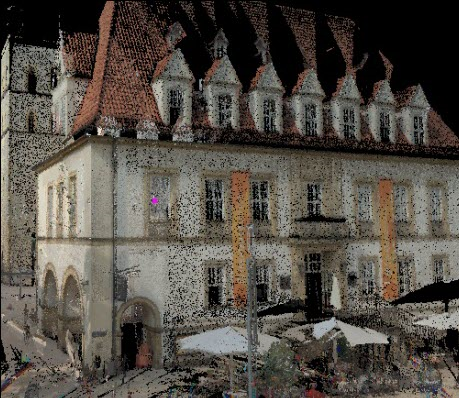
    <br>
    <figcaption>Figure 1. Visualization of point cloud dataset with RGB values [3]. The features apart from x, y, and z values, such as intensity and number of returns are quite valuable for the task of classification, but at the same, time they are sensor dependent and could become the main reasons for loss of generalization.</figcaption>
</figure>

### Point Cloud Segmentation

Point cloud segmentation is a task where each point in the point cloud is assigned a label, representing a real-world entity as described above. It is different from point cloud categorization where the complete point cloud dataset is given one label.

<figure>
        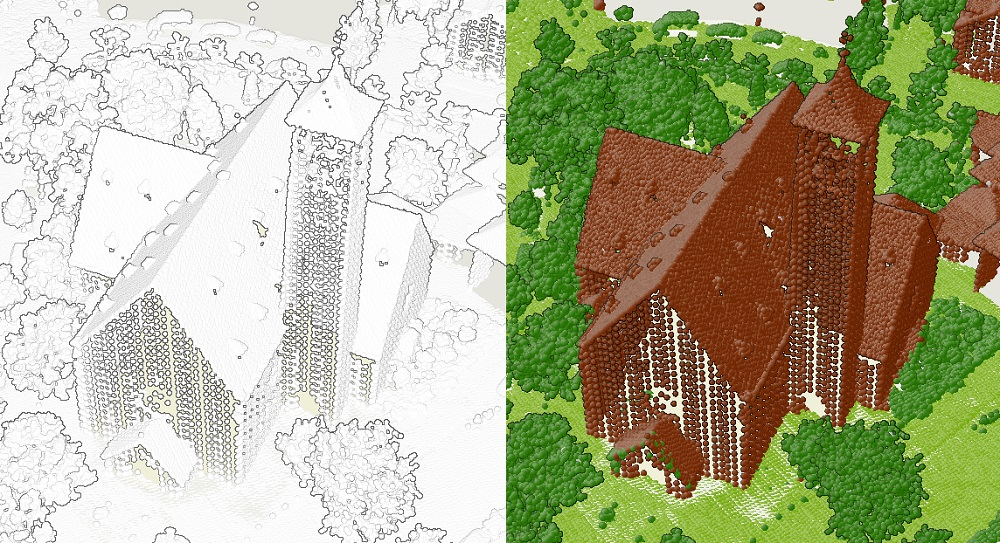
    <br>
    <figcaption>Figure 2. On the left side, raw Lidar points can be seen. And for the same area, on the right side, we have classified points, where class codes are assigned to different colors. [2]</figcaption>

</figure>

Similar to how it's done with traditional convolutional neural networks, the point cloud segmentation process involves training – where the neural network learns from an already classified (labeled) point cloud dataset, where each point has a unique class code (see Figure 2. right image). These class codes are used to represent feature/s that we want the neural network to recognize. Note that one should not use a ‘thinned-out’ representation of a point cloud dataset that preserves only class codes of interest but drops a majority of the undesired return points, as we would like the neural network to learn and be able to differentiate points of interest class code and those that are not. Likewise, additional attributes that are present in training datasets, for example, Intensity, RGB, number of returns etc., will improve the model’s accuracy but could inversely affect it if those parameters are not present in the datasets used for inferencing. As a result, it's recommended to use either a labeled portion of the data (on which we are planning to do the classification) or to use a more generalized training model built with the most common attributes (for example, a model trained to differentiate only with the help of x, y, and z values would be the most generic model to use).

When training a PointCNN model, the raw point cloud dataset is first converted into blocks of points containing a specific number of points. These blocks then get passed into the model for training along with their labels. A similar process is followed when using the model for predictions as well.

### X-Conv Operation

As described in the Introduction section, a core part of the PointCNN framework is the X-Conv operation which is analogous to the convolution operation in CNNs. This operator performs a series of operations on a processed form of point cloud blocks, such as sampling and normalization using K-Nearest Neighbors. 

Let's illustrate this step with an example. The first step involves sampling several points, let's call it sample P from the input set of points N. Then, for P number of points we find K nearest neighbors from N points. This process is performed to form a local neighborhood of points for each point in P. This local neighborhood of points is then brought to a local coordinate space for each neighborhood. After these operations, we get an array of points of the shape (P, K, 3+E), where E is the number of extra features present (such as intensity, RGB values or the number of returns), other than  x, y, and z.

<figure>
        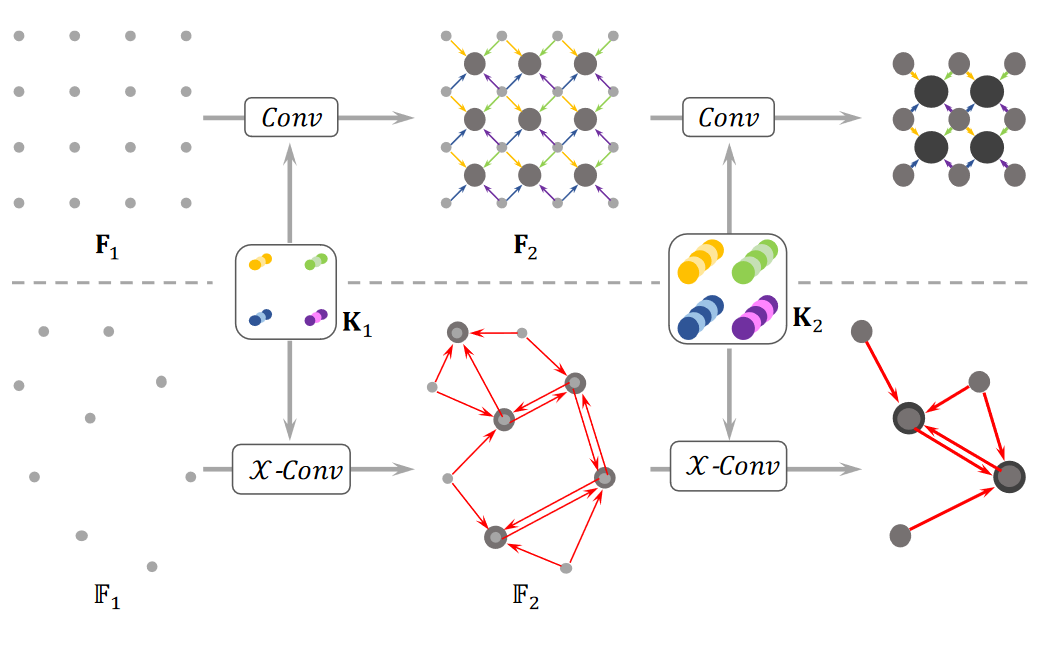
    <br>
    <figcaption>Figure 3. A diagram illustrating the difference and similarities of hierarchical convolution and PointCNN. The process above the dotted line denotes CNN in regular grids where convolutions are recursively applied on local grid patches. The process involves grid reductions – as done similarly in raster processing or meshing reducing the grid resolution successively (4X4⇥3X3⇥2X2), while increasing the channel number (visualized by dot thickness). Similarly, in point clouds, X-Conv is recursively applied to “project” or “aggregate” information, from the neighborhoods into fewer representative points (9⇥5⇥2) but each with richer information. [1]</figcaption>
</figure>

### PointCNN Segmentation Architecture

The PointCNN network for point cloud segmentation has a similar architecture to U-Net, as described in the "How U-net works?" [4] guide. Here too, we use an encoder-decoder paradigm, where the encoder reduces the number of points while increasing the number of channels. Then, the decoder part of the network increases the number of points, and the number of channels is incrementally reduced. The network also uses ‘skip connections’ similar to how it's done in the U-Net architecture. 

The difference is that the network processes a block of points as input and uses the X-Conv operation instead of Conv2D.

To state it succinctly, PointCNN differs from conventional grid-based CNNs primarily due to the application of X-Conv layers. Even then, the general process is similar to how CNNs are used in grid-based convolution frameworks. The main differences are with respect to:

1. The way the local regions are extracted (K ⇥K patches vs. K neighboring points around representative points).
2. The way the information from local regions is learned (Conv vs. X-Conv). [1]

<figure>
        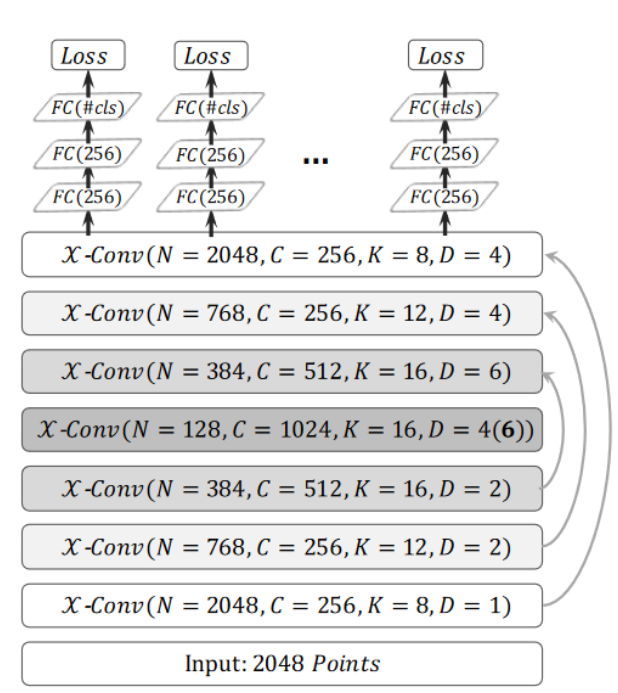
    <br>
    <figcaption>Figure 4. A Generalized representation of a PointCNN for Segmentation Architecture [1]. In each X-Conv operation, N represents the number of points in next layer, C represents the number of channels, K represents the number of nearest neighbors and D represents the dilation rate. [1]</figcaption>
</figure>

### Implementation in `arcgis.learn`

When training a PointCNN model using `arcgis.learn`, the raw point cloud dataset in LAS files is first converted into blocks of points, containing a specific number of points along with their class codes.

```python
path = r'path\to\las_files' 
output_path = r'path\to\exported_data' 
export_point_dataset(path, output_path, 50.0, 8192, [('intensity', 5000, 0), ('num_returns', 5, 0)]
```

These blocks are used to create a `data bunch` object that is passed into the `PointCNN` model for training.

```python
colormap = {'0':[220,220,220], '1':[255,0,0], '2':[0,255,0], '3':[0,0,255]}
data = prepare_data(output_path, dataset_type='PointCloud', batch_size=2, color_mapping=colormap)
pointcnn = PointCNN(data)
```

#### For advanced users 

We can also specify all the additional parameters while initializing PointCNN by using certain keyword arguments. One of those is `encoder_params` keyword argument, which can be used to specify the number of output channels for each layer in the encoder. The decoder of the network is built accordingly.

There are mainly four things that we need to define in the encoder: `out_channels`, `P`, `K`, and `D`. All of these are supplied as a 'python list'. The `out_channel` specifies the number of channels after each layer. While, for each layer `P`, `K` and `D` specify the 'number of points', 'k-nearest-neighbor', and 'dilation rate' respectively. Additionally, one can specify `m`, which is the multiplicative factor, that is multiplied by each element of the `out_channel` list. The other keyword arguments are `dropout` and `sample_point_num`. The `dropout` keyword argument specifies the amount of regularization we want to add in the model, with its value ranging between 0 and 1. The `sample_point_num` keyword argument specifies the number of points that will actually be used for training the model. It is usually equal to the number of maximum points in a block, while exporting the point cloud dataset.

A typical usage looks like:

```python
pointcnn = PointCNN(data=data, 
                    encoder_params={'out_channels':[16, 32, 64, 96],
                                    'P':[-1, 768, 384, 128],
                                    'K':[12, 16, 16, 16],
                                    'D':[1, 1, 2, 2],
                                    'm':8
                                    },  
                    dropout=0.5,
                    sample_point_num=8192
                   )
```

## Setting up the environment

Though the instructions below are for a typical Windows operating system, the procedures  also apply (with minor modifications) to other operating systems. For Ubuntu/Linux, you may find [this script](https://github.com/Esri/arcgis-python-api/tree/master/misc/tools/pointcnn_ubuntu.sh) useful.

Make sure to update your 'GPU driver' to a recent version and use 'Administrator Rights' for all the steps, written in this guide. Below, are the instructions to setup the required 'conda environment':






### For ArcGIS Pro users:

<p> </p>

Open 'Python Command Prompt' <i>(included with ArcGIS Pro)</i> and separately execute each of the following commands.


`conda create -n arcgis-api-env --clone arcgispro-py3`

`activate arcgis-api-env`

`conda install -c esri arcgis=1.8.1`

`conda install -c esri -c fastai -c pytorch scikit-image=0.15.0 pillow=6.2.2 libtiff=4.0.10 fastai=1.0.60 pytorch=1.4.0 torchvision=0.5.0 cudatoolkit=10.1.243`

`conda install -c plotly plotly=4.5.4 plotly-orca=1.3.1 nodejs=10.13 tensorflow-gpu=2.1.0`

`pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 torch-cluster==latest+cu101 torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html`

`pip install torch-geometric==1.5.0 transforms3d==0.3.1 laspy==1.7.0`

`jupyter labextension install @jupyter-widgets/jupyterlab-manager@2.0.0 arcgis-map-ipywidget@1.8.1 jupyterlab-plotly@1.5.3 plotlywidget@1.5.3 --dev-build=False --minimize=False`

<br><br>

### For Anaconda users:

<p> </p>

Open 'Anaconda Prompt' and separately execute each of the following commands.

- Anaconda can be installed from [here](https://repo.anaconda.com/archive/Anaconda3-2020.02-Windows-x86_64.exe). 

`conda create -n arcgis-api-env python=3.6.10`

`conda activate arcgis-api-env`

`conda install -c esri arcgis=1.8.1`

`conda install -c esri -c fastai -c pytorch scikit-image=0.15.0 pillow=6.2.2 libtiff=4.0.10 fastai=1.0.60 pytorch=1.4.0 torchvision=0.5.0 cudatoolkit=10.1.243 jupyterlab=2.0.1`

`conda install -c plotly plotly=4.5.4 plotly-orca=1.3.1 psutil=5.7.0 nodejs=10.13 h5py=2.10.0 gdal=2.3.3 tensorflow-gpu=2.1.0`

`pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 torch-cluster==latest+cu101 torch-spline-conv==latest+cu101 -f https://pytorch-geometric.com/whl/torch-1.4.0.html`

`pip install torch-geometric==1.5.0 transforms3d==0.3.1 laspy==1.7.0`

`jupyter labextension install @jupyter-widgets/jupyterlab-manager@2.0.0 arcgis-map-ipywidget@1.8.1 jupyterlab-plotly@1.5.3 plotlywidget@1.5.3 --dev-build=False --minimize=False`

<br><br>

### References

* [1] Yangyan Li, Rui Bu, Mingchao Sun, Wei Wu, Xinhan Di: “PointCNN: Convolution On $\mathcal{X}$-Transformed Points"

* [2] Dmitry Kudinov: "PointCNN: replacing 50,000 man hours with AI"

* [3] Autodesk Help: "About Point Cloud Color Stylization and Visual Effects" https://knowledge.autodesk.com/support/autocad/learn-explore/caas/CloudHelp/cloudhelp/2020/ENU/AutoCAD-Core/files/GUID-75EBFA48-CB7E-4E91-A1BB-167D96A7119F-htm.html

* [4] Esri: "How U-net works?" https://developers.arcgis.com/python/guide/how-unet-works/